In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import utils
import matplotlib.pyplot as plt
import so_decadal_variability.calc as socalc
import numpy as np
plt.style.use('ggplot')

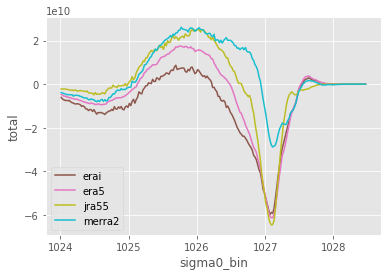

In [3]:
G = {}
# Load observational data
fluxnames=['erai','era5','jra55','merra2']
colors={'erai':'tab:brown','era5':'tab:pink','jra55':'tab:olive','merra2':'tab:cyan'}
names = {'erai':'ERA-interim','era5':'ERA5','jra55':'JRA55','merra2':'MERRA2'}
oceanname='en4'
density = 'sigma0'
dg = 0.02
for fluxname in fluxnames:
    tmp = xr.open_mfdataset('../../data/processed/'+
                            fluxname+'_'+oceanname+
                            '/G.'+density+'.'+str(dg)+'.*.nc')
    # Rechunk data
    G[fluxname] = tmp.chunk({'time':len(tmp['time'])})
    G[fluxname]['total'].mean('time').plot(label=fluxname,color=colors[fluxname])
plt.gca().legend()

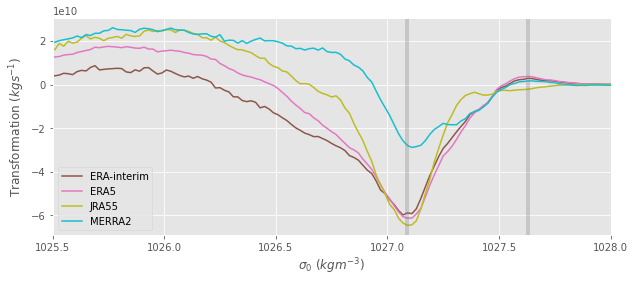

In [17]:
fig,ax = plt.subplots(figsize = (10,4))
for fluxname in fluxnames:
    x = G[fluxname]['sigma0_bin']
    y = G[fluxname]['total'].mean('time')
    ax.plot(x,y,label=names[fluxname],color=colors[fluxname])
ylim = ax.get_ylim()
ax.plot([1027.09,1027.09], ylim,color='gray',linewidth=4,alpha=0.3)
ax.plot([1027.63,1027.63], ylim,color='gray',linewidth=4,alpha=0.3)
ax.set_xlim([1025.5,1028])
ax.set_ylabel('Transformation ($kgs^{-1}$)')
ax.set_xlabel('$\sigma_0$ ($kgm^{-3}$)')
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(loc='lower left')
fig.savefig('../../figures/reanalyses_swmt_all.png',dpi=300)

### Temporal variability : all

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: sh

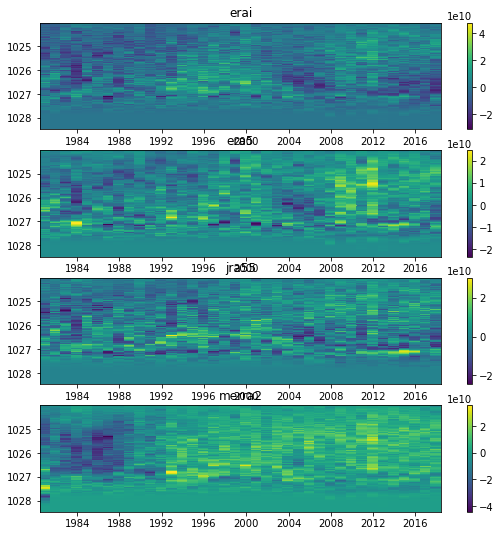

In [7]:
fig, ax = plt.subplots(figsize=(9,9),nrows=len(fluxnames))
for i,fn in enumerate(fluxnames):
    im = ax[i].pcolormesh(socalc._annual(G[fn]['time']),
                     G[fluxname]['sigma0_bin'],
                     socalc._annualanom(G[fn]['total']).transpose())
    ax[i].invert_yaxis()
    ax[i].set_title(fn)
    plt.colorbar(im,ax=ax[i])

### Selecting watermasses

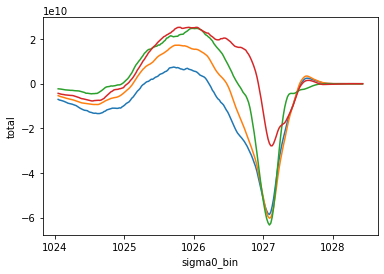

In [27]:
bounds={}
for fn in fluxnames:
    X = G[fn]['total'].mean('time')
    Xsmooth = X.rolling({'sigma0_bin':5},center=True).mean()
    Xsmooth.plot()
    ex = utils.operations.extrema(Xsmooth,dim='sigma0_bin',order=10)
    c = utils.operations.crossing(Xsmooth,dim='sigma0_bin')
    bounds[fn] = np.sort(np.concatenate((c.values, ex['min'].values, ex['max'].values)))

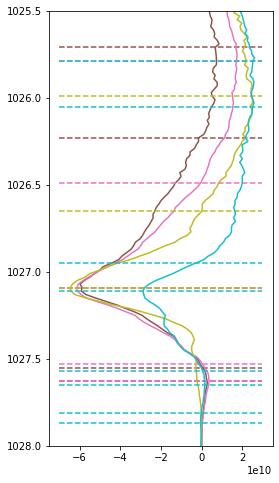

In [28]:
fig,ax=plt.subplots(figsize=(4,8))
xlims = np.array([-7E10,3E10])
for fn in fluxnames:
    ax.plot(G[fn]['total'].mean('time'),G[fn]['sigma0_bin'],color=colors[fn])
    for b in bounds[fn]:
        ax.plot(xlims,[b,b],color=colors[fn],linestyle='--')
ax.set_ylim([1025.5,1028])
ax.invert_yaxis()

In [29]:
bounds

{'erai': array([1024.63, 1025.31, 1025.71, 1026.23, 1027.09, 1027.55, 1027.63]),
 'era5': array([1024.61, 1025.13, 1025.79, 1026.49, 1027.09, 1027.53, 1027.63]),
 'jra55': array([1024.53, 1024.97, 1025.99, 1026.65, 1027.09, 1028.11, 1028.13,
        1028.21, 1028.35, 1028.37, 1028.39, 1028.41, 1028.43]),
 'merra2': array([1024.55, 1025.05, 1025.79, 1026.05, 1026.95, 1027.11, 1027.57,
        1027.65, 1027.81, 1027.87, 1028.19])}

### Evaluate surface-forced destruction
Pick preliminary bounds as $\sigma_0 = $ 1027.09 to 1027.63

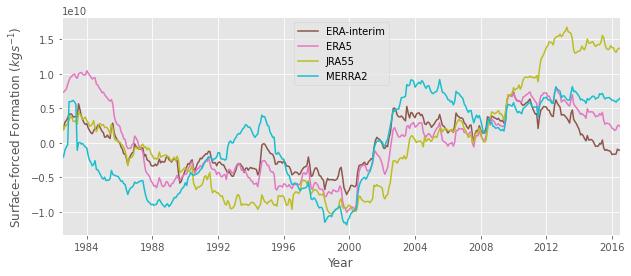

In [31]:
fig,ax=plt.subplots(figsize=(10,4))
for fn in fluxnames:
    dG = -1*G[fn].diff('sigma0_bin')
    wmd = dG.sel(sigma0_bin=slice(1027.09,1027.65)).sum('sigma0_bin')
    x = wmd['time']
    y = wmd['total'].rolling(time=60,center=True).mean()
    ax.plot(x,socalc._anom(y),color=colors[fn],label=names[fn])
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlabel('Year')
ax.set_ylabel('Surface-forced Formation ($kgs^{-1}$)')

# Add ecco data
# ecco = xr.open_dataset('../../data/processed/ECCO/wmfanoms_cts_bowl_watermasses.nc')
# x = ecco['time']
# y = ecco['bin_FORC'].isel(gamma_n_bins=3)
# ax.plot(x,y,label='ECCO',color='tab:green',linewidth=3)

ax.legend(loc='upper center')
fig.savefig('../../figures/reanalyses_swmf_ucdw_timeseries_ecco.png',dpi=300)

<xarray.Dataset>
Dimensions:       (gamma_n_bins: 6, time: 312)
Coordinates:
  * time          (time) datetime64[ns] 1992-01-31 1992-02-29 ... 2017-12-31
  * gamma_n_bins  (gamma_n_bins) float64 25.17 26.1 27.08 27.62 28.03 28.62
Data variables:
    bin_ADV       (gamma_n_bins, time) float64 ...
    bin_DIF       (gamma_n_bins, time) float64 ...
    bin_FORC      (gamma_n_bins, time) float64 ...
    bin_TEN       (gamma_n_bins, time) float64 ...
    bin_FORCDIF   (gamma_n_bins, time) float64 ...

In [36]:
wmd

<xarray.Dataset>
Dimensions:  (time: 468)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T00:30:00 ... 2018-12-01T00:30:00
Data variables:
    heat     (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    fw       (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    total    (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>